<a href="https://colab.research.google.com/github/shu-nya/Image-Classification-of-White-Blood-Cells/blob/master/WBC_Classification_with_VGG_and_SMOTE_and_classify_images_documented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import the necessary libraries

In [ ]:
!pip install imblearn


In [ ]:
import numpy as np
import cv2
import os
import shutil

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

from keras.models import Sequential
from keras import applications
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


## Mount google drive to load the dataset

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# path to the base folder

BASE_DIR = '/content/drive/MyDrive/taskMedPrime'


In [ ]:
# number of classes into which the classifications are to be made
num_classes = 9

# classes into which the classifications are to be made
classes = ['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes', 'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils']


## Create the variables X and y

In [ ]:
# method to get the images as independent variable X and their labels as the dependent variable y

def get_data(folder):
    X = []
    y = []

    # if the image files in the folder wbc are not empty then read the files
    # and convert the images as numpy arrays
    # append the image numpy arrays to the independent variable X
    # and append their labels to y

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):

            for image_filename in os.listdir(folder + '/' + wbc_type):
                img_file = cv2.imread(folder + '/' + wbc_type + '/' + image_filename)

                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)

    # create numpy arrays of X and y

    X = np.asarray(X)
    y = np.asarray(y)

    return X,y


In [ ]:
# call the get_data method using the path to the train and test folders as arguments
# to get the variables X_train, y_train, X_test and y_test

X_train, y_train = get_data(BASE_DIR + '/train')
X_test, y_test = get_data(BASE_DIR + '/test')


In [ ]:
# normalize X_train and X_test
# it will make images contribute more evenly to the total loss

X_train = X_train * 1./255.
X_test = X_test * 1./255.


In [ ]:
# summarize class distribution in the train dataset after augmentation

counter = Counter(y_train)
print(counter)


Counter({'neutrophils': 250, 'lymphocytes': 234, 'monocytes': 106, 'bands': 103, 'eosinophils': 102, 'metamyelocytes': 102, 'myelocytes': 89, 'basophils': 88, 'blasts': 84})


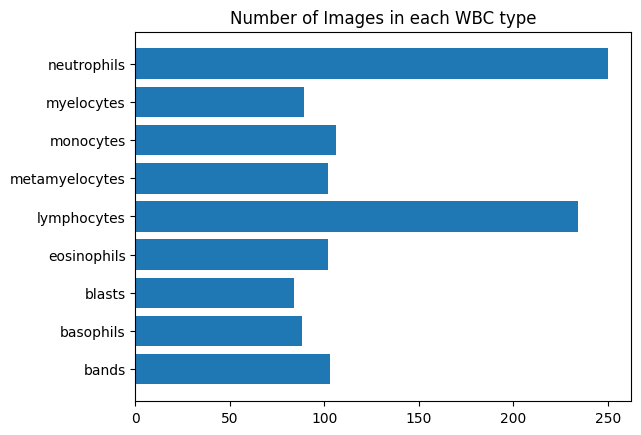

In [ ]:
# plot the number of images in each sub-folder of the train dataset

y_train_unique_counts = np.unique(y_train, return_counts=True)

plt.title('Number of Images in each WBC type')
plt.barh(y_train_unique_counts[0], y_train_unique_counts[1])
plt.show()


## SMOTE to treat the imbalance in the dataset

In [ ]:
# get all the dimensions of X_train

n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]
print(f"Shape of X_train before reshape: {X_train.shape}")


Shape of X_train before reshape: (1158, 256, 256, 3)


In [ ]:
# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight) type data

X_train_reshaped = X_train.reshape(n_samples, n_channels*height*width)
print(f"Shape of X_train after reshape: {X_train_reshaped.shape}")


Shape of X_train after reshape: (1158, 196608)


In [ ]:
# initialize the SMOTE model

smote = SMOTE(k_neighbors=5, random_state=62)


In [ ]:
# perform re-sampling on modified X given y of the train data

X_smote, y_smote = smote.fit_resample(X_train_reshaped, y_train)


In [ ]:
# number of images before and after applying SMOTE

print(f'Before re-sampling, the number of images: {len(X_train):2}')
print(f'After re-sampling, the number of images: {len(X_smote):2}')


Before re-sampling, the number of images: 1158
After re-sampling, the number of images: 2250


### Observations:

1. The number of samples in the train dataset has increased from 1158 to 2250 after applying SMOTE

In [ ]:
# summarize the new class distribution after applying SMOTE on the train data

counter = Counter(y_smote)
print(counter)


Counter({'bands': 250, 'basophils': 250, 'blasts': 250, 'eosinophils': 250, 'lymphocytes': 250, 'metamyelocytes': 250, 'monocytes': 250, 'myelocytes': 250, 'neutrophils': 250})


(array(['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes',
       'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils'],
      dtype='<U14'), array([250, 250, 250, 250, 250, 250, 250, 250, 250]))


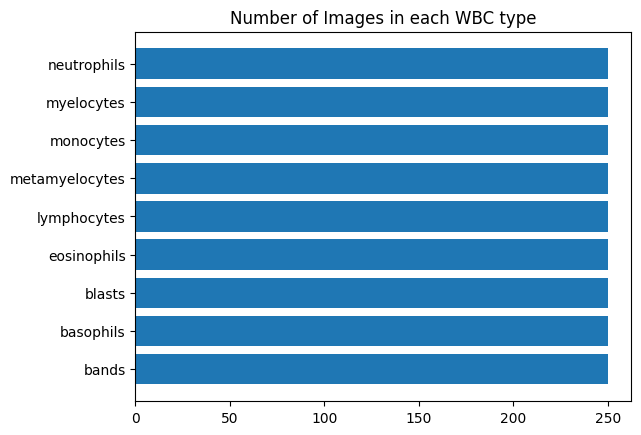

In [ ]:
# view the resulting balanced data (modified distribution) after applying SMOTE

y_smote_unique_counts = np.unique(y_smote, return_counts=True)
print(y_smote_unique_counts)

plt.title('Number of Images in each WBC type')
plt.barh(y_smote_unique_counts[0], y_smote_unique_counts[1])
plt.show()


### Observations:

1. Each class in the train dataset has 250 samples after applying SMOTE
2. This removes the imbalance in the train dataset

In [ ]:
# assign the values of X_smote and y_smote to X_train and y_train respectively

X_train, y_train = X_smote, y_smote


In [ ]:
# re-shape the dimension of X_train that was changed to apply SMOTE

n_samples, height, width, n_channels = 250*9, 256, 256, 3

X_train = X_train.reshape(n_samples, height, width, n_channels)


In [ ]:
# get all the dimensions of X_train

n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]
print(f"Shape of X_train before reshape: {X_train.shape}")


Shape of X_train before reshape: (2250, 256, 256, 3)


### Observations:

1. Shape of X_train has been restored for training the model

## One-hot encoding of the labels

In [ ]:
# Convert the labels in y_train using one-hot encoding

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)


## Model: VGG16

In [ ]:
# define the variables to be used in the model

num_classes = 9

epochs = 10
batch_size = 32


In [ ]:
# define the VGG16 model

base_model = applications.VGG16(include_top=False, weights='imagenet')
input = Input(shape=(256, 256, 3), name = 'image_input')
vgg_output = base_model(input)

top_model = Flatten()(vgg_output)
top_model = Dense(64, activation='relu')(top_model)
predictions = Dense(num_classes, activation='softmax', name='prediction_layer')(top_model)

model = Model(inputs=input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers

layers = base_model.layers[:-2]
for layer in layers:
    layer.trainable = False


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# compile the model (should be done after setting layers to non-trainable)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


### Note:

Accuracy is used as a metric for model evaluation because it is more important that the model classifies each image correctly rather than penalizing the False-Positives (Precision) or the False-Negatives (Recall) or penalizing both (F1).

In [ ]:
# model summary

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 prediction_layer (Dense)    (None, 9)                 585       
                                                                 
Total params: 16,812,489
Trainable params: 4,457,609
Non-trainable params: 12,354,880
_________________________________________________________________


In [ ]:
# fit the model on train data

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True, verbose=1)


Epoch 1/10
57/57 [==============================] - 33s 301ms/step - loss: 2.6595 - accuracy: 0.4644 - val_loss: 3.1047 - val_accuracy: 0.0067
Epoch 2/10
57/57 [==============================] - 11s 194ms/step - loss: 0.8156 - accuracy: 0.7306 - val_loss: 1.6542 - val_accuracy: 0.4511
Epoch 3/10
57/57 [==============================] - 11s 188ms/step - loss: 0.3944 - accuracy: 0.8761 - val_loss: 1.6631 - val_accuracy: 0.4711
Epoch 4/10
57/57 [==============================] - 11s 191ms/step - loss: 0.1925 - accuracy: 0.9400 - val_loss: 2.6777 - val_accuracy: 0.3956
Epoch 5/10
57/57 [==============================] - 11s 193ms/step - loss: 0.1197 - accuracy: 0.9567 - val_loss: 0.6379 - val_accuracy: 0.8222
Epoch 6/10
57/57 [==============================] - 11s 196ms/step - loss: 0.1006 - accuracy: 0.9772 - val_loss: 1.2940 - val_accuracy: 0.6689
Epoch 7/10
57/57 [==============================] - 12s 204ms/step - loss: 0.0685 - accuracy: 0.9872 - val_loss: 1.8338 - val_accuracy: 0.6400

In [ ]:
# save the weights of the model

model.save_weights('vgg_top.h5')


In [ ]:
# load the weights of the moodel

model.load_weights('vgg_top.h5')


## Make predictions on the test dataset that was created using 20% images of the wbc folder

In [ ]:
# predictions on the test dataset

y_pred = model.predict(X_test)

print(y_pred)


7/7 [==============================] - 6s 885ms/step
[[1.3585199e-08 4.5656844e-04 2.0685566e-13 ... 2.7117966e-04
  6.0474789e-03 6.1128126e-06]
 [6.8576663e-04 9.4036203e-08 1.7725731e-07 ... 1.2718051e-03
  1.9160411e-06 9.8258334e-01]
 [1.8450766e-05 6.7128786e-10 2.1832362e-12 ... 2.9066907e-05
  6.4727737e-11 9.9948823e-01]
 ...
 [1.5754960e-02 4.8673159e-09 5.5631575e-09 ... 3.3602294e-06
  1.5342486e-07 9.8252583e-01]
 [2.0355514e-01 2.2528241e-08 2.5449097e-07 ... 9.6610514e-05
  3.0199553e-06 7.9550707e-01]
 [1.8370044e-03 2.3492580e-10 1.4682155e-12 ... 1.6339909e-06
  3.1751224e-10 9.9041945e-01]]


In [ ]:
# rounding the elements of the y_pred array to the nearest integer using np.rint

y_pred = np.rint(y_pred)

print(y_pred)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
# print the accuracy obtained on the test data

print(accuracy_score(y_test, y_pred))


0.7663551401869159


In [ ]:
# the confusion matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))


[[ 4  0  0  0  0  2  0  0  6]
 [ 1  2  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2]
 [ 0  0  0  6  0  0  0  0  4]
 [ 0  0  0  0 72  0  0  3  1]
 [ 0  3  0  0  0  3  1  0  3]
 [ 1  2  0  0  0  0  9  0  0]
 [ 0  0  0  0  2  2  0  0  0]
 [ 7  0  0  2  5  1  0  1 68]]


# Making prediction on the *classify-images* dataset

In [ ]:
# define get_data_classify_images to load the images in the classify-images folder

def get_data_classify_images(folder):

    X = []

    for image_filename in os.listdir(folder):
        img_file = cv2.imread(folder + '/' + image_filename)

        if img_file is not None:
            img_arr = np.asarray(img_file)
            X.append(img_arr)

    X = np.asarray(X)

    return X


In [ ]:
# call the get_data_classify_images method using the path of classify-images folder as the argument

X_classify_images = get_data_classify_images(BASE_DIR + '/classify-images')


In [ ]:
# load weights of the model

model.load_weights('vgg_top.h5')


In [ ]:
# prediction on the classify-images data

y_pred_classify_images = model.predict(X_classify_images)


2/2 [==============================] - 5s 5s/step


In [ ]:
# rounding the elements of the y_pred array to the nearest integer using np.rint

y_pred_classify_images = np.rint(y_pred_classify_images)

print('Prediction on the classify-images data')
print()

print(y_pred_classify_images)


Prediction on the classify-images data

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
